<a href="https://colab.research.google.com/github/benoitai/colab_nb/blob/main/pmf_contamination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import os,sys, datetime, json,  math
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import optimize, stats
from scipy.stats import binom
from collections import namedtuple
import logging
logger = logging.getLogger()
import timeit

In [79]:
DATA = 'data/'
OUTPUT = 'output/'
x=[(print(f'create {x}'), os.makedirs(x)) for x in [DATA,OUTPUT] if not os.path.isdir(x)]
!pwd

/content


In [293]:
#@title segments
def read_segment_file(segments_file):
    seg = pd.read_csv(segments_file, comment='#', sep='\t')
    return seg

def renxy(m):
    m['contig'] = m['contig'].astype(str).copy()
    if 'X' in m.contig.unique():
      m.loc[m['contig'] == 'X', 'contig'] = '23'
    if 'Y' in m.contig.unique():
      m.loc[m['contig'] == 'Y', 'contig'] = '24'

    m['contig'] = m['contig'].astype(int).copy()
    m = m.sort_values(by=['contig']).copy()
    m.reset_index(inplace=True, drop=True)
    return m

def restore_xy(m):
    m['contig'] = m['contig'].astype(str).copy()
    if '23' in m.contig.unique():
      m.loc[m['contig'] == '23', 'contig'] = 'X'
    if '24' in m.contig.unique():
      m.loc[m['contig'] == '24', 'contig'] = 'Y'
    return m

def plot_seg(s1, s2,t1,t2, displayit=False):
    maf1 = f'maf_{t1}'
    maf2 = f'maf_{t2}'

    seg1 = read_segment_file(s1)
    seg1 = renxy(seg1)

    seg1.rename(columns={'contig': 'contig','start': 'start_1','end': 'end_1','minor_allele_fraction': maf1}, inplace=True)

    seg2 = read_segment_file(s2)
    if displayit:
      display(seg1)
      display(seg2)
    seg2 = renxy(seg2)
    seg2.rename(columns={'contig': 'contig_2','start': 'start_2','end': 'end_2', 'minor_allele_fraction': maf2}, inplace=True)

    m =  pd.concat([seg1,seg2], axis=1)

    m = m[['contig','start_1','start_2','end_1','end_2',maf1,maf2]].copy()
    m = restore_xy(m)
    display(m)
    x_values = m.contig
    y1_values = m[maf1]
    y2_values = m[maf2]

    # Create a line plot
    plt.plot(x_values, y1_values)
    plt.plot(x_values, y2_values)

    # Add points to the plot
    plt.scatter(x_values, y1_values, color="blue", marker="x", label=maf1, alpha=.7)
    plt.scatter(x_values, y2_values, color="orange", marker="o", label=maf2, alpha=.7)
    plt.title(f'{t1} vs {t2}')
    plt.xticks(x_values)
    plt.xlabel('contig')
    plt.ylabel('maf')
    plt.legend(bbox_to_anchor=(1., 1.15), loc='right')
    plt.xticks(rotation=90)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()



In [205]:
def calculateErrorRate(sites):
    sites['total_count'] = sites.loc[:, [
        'ref_count', 'alt_count', 'other_alt_count']
    ].sum(axis=1)
    totalBases = sites['total_count'].sum(axis=0)
    otherAltBases = sites['other_alt_count'].sum(axis=0)
    return 1.5 * (otherAltBases / totalBases)

In [160]:
#@title pileup
def final_info(final):
    metaLine = open(final, 'r').readline()
    string_dic = metaLine.split("=")[1]
    bmeta = eval(string_dic)
    model_contamination = bmeta['model_contamination']
    # gatk final output sites
    df_final = pd.read_csv(final, comment='#', sep='\t', header=0)
    df_final = df_final.sort_values(['contig','position'])
    df_final.reset_index(inplace=True, drop=True)
    print(f'{os.path.basename(final)}: model_contamination={model_contamination}, total sites={df_final.shape[0]}')
    return model_contamination, df_final

def read_filter_pileup(myfile):
    MIN_COVERAGE = 10
    LOW_COVERAGE_THRESHOLD = 0.5
    HIGH_COVERAGE_THRESHOLD = 3.0

    sites = pd.read_csv(myfile, sep="\t", skiprows=1)
    sites['total_count'] = sites.loc[:, [
        'ref_count', 'alt_count', 'other_alt_count']
    ].sum(axis=1)
    covered_sites = sites[sites['total_count'] > MIN_COVERAGE]
    median_coverage = covered_sites['total_count'].median(axis=0)
    mean_coverage = covered_sites['total_count'].mean(axis=0)

    low_coverage = median_coverage * LOW_COVERAGE_THRESHOLD
    high_coverage = mean_coverage * HIGH_COVERAGE_THRESHOLD

    keep_sites = covered_sites[
        (covered_sites['total_count'] > low_coverage)
        & (covered_sites['total_count'] < high_coverage)].copy()
    # keep_sites.drop('total_count', axis=1, inplace=True)
    keep_sites['allele_frequency'] = keep_sites[
        'allele_frequency'].map('{:.7f}'.format)
    if False:
        logger.info(f'Input {myfile} sited: {sites.shape[0]}, filtered to {keep_sites.shape[0]}')
    return keep_sites

def read_unfilter_pileup(myfile):
    sites = pd.read_csv(myfile, sep="\t", skiprows=1)
    sites['total_count'] = sites.loc[:, [
        'ref_count', 'alt_count', 'other_alt_count']
    ].sum(axis=1)
    return sites

def pileup_info(myfile, low_coverage_ratio_threshold):
        if not os.path.exists(myfile):
            logger.info('fskip pileup_info, {myfile} not  exist')
            failed_ps_info = pd.DataFrame([{'count': "-1",
                                            'low_coverage_ratio_threshold':'-1',
                                            'x_median': "-1", 'three_mean': "-1",
                                            'p_low_coverage': "-1", 'p_high_coverage': "-1",
                                            'ptc25': "-1", 'ptc75': "-1",
                                            'ptc90': "-1", 'mean': "-1", 'median': "-1",
                                            'psaf25': "-1", 'psaf50': "-1", 'psaf75': "-1",
                                            }])
            return failed_ps_info

        sites = pd.read_csv(myfile, sep="\t", skiprows=1)
        sites['total_count'] = sites.loc[:, [
            'ref_count', 'alt_count', 'other_alt_count']
        ].sum(axis=1)
        MIN_COVERAGE = 10
        covered_sites = sites[sites['total_count'] > MIN_COVERAGE]
        psaf25 = covered_sites.allele_frequency.quantile(0.25)
        psaf50 = covered_sites.allele_frequency.quantile(0.5)
        psaf75 = covered_sites.allele_frequency.quantile(0.75)

        d = covered_sites.total_count.describe()
        count = d.loc['count']
        mean = d.loc['mean']
        ptc25 = d.loc['25%']
        median = d.loc['50%']
        ptc75 = d.loc['75%']
        ptc90 = covered_sites.total_count.quantile(0.9)
        x_median = float(low_coverage_ratio_threshold) * median
        three_mean = 3 * mean
        p_low_coverage = stats.percentileofscore(
            covered_sites['total_count'], x_median, kind='rank')
        p_high_coverage = stats.percentileofscore(
            covered_sites['total_count'], three_mean, kind='rank')
        low_high = [x_median, three_mean]
        iqr = [ptc25, ptc75]
        ps_info = pd.DataFrame([{'count': count,
                                'low_coverage_ratio_threshold':low_coverage_ratio_threshold,
                                'x_median': x_median, 'three_mean': three_mean,
                                'p_low_coverage': p_low_coverage, 'p_high_coverage': p_high_coverage,
                                'ptc25': ptc25, 'ptc75': ptc75,
                                'ptc90': ptc90, 'mean': mean, 'median': median,
                                'psaf25': psaf25, 'psaf50': psaf50, 'psaf75': psaf75,
                                }])
        for c in ['x_median', 'three_mean', 'p_low_coverage', 'p_high_coverage', 'ptc25', 'ptc75', 'ptc90', 'mean', 'psaf25', 'psaf50', 'psaf75']:
            ps_info[c] = ps_info[c].astype(float).apply(lambda x: round(x, 2))
        return ps_info

In [83]:
#@title igd
def igd_to_df(v):
    if v is None:
        v = {
            "ref_15_90_10": v,
            "ref_25_90_10": v,
            "ref_30_90_10": v,
            "ref_35_90_10": v,
            "alt_15_90_10": v,
            "alt_20_90_10": v,
            "alt_25_90_10": v,
            "alt_35_90_10": v,
            "ref_15_100_10": v,
            "ref_25_100_10": v,
            "ref_35_100_10": v,
            "alt_15_100_10": v,
            "alt_25_100_10": v,
            "alt_35_100_10": v,
            "n_ref_15_90_10": v,
            "n_ref_25_90_10": v,
            "n_ref_30_90_10": v,
            "n_ref_35_90_10": v,
            "n_alt_15_90_10": v,
            "n_alt_20_90_10": v,
            "n_alt_25_90_10": v,
            "n_alt_35_90_10": v,
            "n_ref_15_100_10": v,
            "n_ref_25_100_10": v,
            "n_ref_35_100_10": v,
            "n_alt_15_100_10": v,
            "n_alt_25_100_10": v,
            "n_alt_35_100_10": v
        }

    RetVal=namedtuple('RetVal',v.keys())
    ret_tuples=RetVal(
                    ref_15_90_10 = v['ref_15_90_10'],
                    ref_25_90_10 = v['ref_25_90_10'],
                    ref_30_90_10 = v['ref_30_90_10'],
                    ref_35_90_10 = v['ref_35_90_10'],
                    alt_15_90_10 = v['alt_15_90_10'],
                    alt_20_90_10 = v['alt_20_90_10'],
                    alt_25_90_10 = v['alt_25_90_10'],
                    alt_35_90_10 = v['alt_35_90_10'],
                    ref_15_100_10 = v['ref_15_100_10'],
                    ref_25_100_10 = v['ref_25_100_10'],
                    ref_35_100_10 = v['ref_35_100_10'],
                    alt_15_100_10 = v['alt_15_100_10'],
                    alt_25_100_10 = v['alt_25_100_10'],
                    alt_35_100_10 = v['alt_35_100_10'],

                    n_ref_15_90_10  = v['n_ref_15_90_10'],
                    n_ref_25_90_10  = v['n_ref_25_90_10'],
                    n_ref_30_90_10  = v['n_ref_30_90_10'],
                    n_ref_35_90_10  = v['n_ref_35_90_10'],
                    n_alt_15_90_10  = v['n_alt_15_90_10'],
                    n_alt_20_90_10  = v['n_alt_20_90_10'],
                    n_alt_25_90_10  = v['n_alt_25_90_10'],
                    n_alt_35_90_10  = v['n_alt_35_90_10'],
                    n_ref_15_100_10 = v['n_ref_15_100_10'],
                    n_ref_25_100_10 = v['n_ref_25_100_10'],
                    n_ref_35_100_10 = v['n_ref_35_100_10'],
                    n_alt_15_100_10 = v['n_alt_15_100_10'],
                    n_alt_25_100_10 = v['n_alt_25_100_10'],
                    n_alt_35_100_10 = v['n_alt_35_100_10']
    )
    v_df = pd.DataFrame.from_records([ret_tuples], columns=RetVal._fields)
    for c in RetVal._fields:
        if 'n_' not in c:
            v_df[c]= v_df[c].astype(float).apply(lambda x:round(x,6))
    return v_df

# calculateContamination funtions

In [84]:
#@title contamination_estimate
def contamination_estimate(homs, oppositeCount, tumorErrorRate):
    '''the actual contamination reported after determine non loh ALT or REF sites
    '''
    opposite_to_ALT_REF = {'ref_count': 'ALT', 'alt_count': 'REF'}
    homs = homs.copy()
    if len(homs) == 0:
        return -1, pd.DataFrame()
    homs['total_count'] = homs.loc[:, [
        'ref_count', 'alt_count', 'other_alt_count']
    ].sum(axis=1)
    homs['allele_frequency'] = homs['allele_frequency'].astype(
        'float64')
    totalDepth = homs['total_count'].sum(axis=0)
    errorDepth = round(totalDepth * tumorErrorRate / 3)
    oppositeDepth = homs[oppositeCount].sum(axis=0)
    contaminationOppositeDepth = max(oppositeDepth - errorDepth, 0)
    if oppositeCount == 'ref_count':
        homs['totalCountByOppositeFrequency'] = homs['total_count'] * \
            (1. - homs['allele_frequency'])
    else:
        homs['totalCountByOppositeFrequency'] = homs['total_count'] * \
            homs['allele_frequency']
    totalDepthWeightedByOppositeFrequency = homs['totalCountByOppositeFrequency'].sum(
        axis=0)
    contaminationEstimate = contaminationOppositeDepth / \
        totalDepthWeightedByOppositeFrequency
    # alt_ref = opposite_to_ALT_REF[oppositeCount]
    # logger.info(f'{alt_ref}: {contaminationOppositeDepth} / {totalDepthWeightedByOppositeFrequency} --> contaminationEstimate={contaminationEstimate} -> {min(contaminationEstimate, 1.0)}')
    return contaminationEstimate, homs

def unscrupulous_hom_sites(homs, oppositeCount, uns_hom_allele_fraction, uns_hom_percentile, uns_min_hom_fraction_threshold):
    homs['total_count'] = homs.loc[:, [
        'ref_count', 'alt_count', 'other_alt_count']
    ].sum(axis=1)

    def getOppsiteFraction(oppositeCount, totalCount):
        return 0 if totalCount == 0 else oppositeCount / totalCount
    homs['OppsiteFraction'] = list(
        map(getOppsiteFraction, homs[oppositeCount], homs['total_count']))

    candidateHoms = homs[homs['OppsiteFraction'] <
                         uns_hom_allele_fraction].copy()   # < 0.15
    percentileX = candidateHoms.OppsiteFraction.quantile(
        uns_hom_percentile)         # percetile90
    # < max(0.1, percetile90)
    fractionThreshold = max(
        uns_min_hom_fraction_threshold, percentileX)
    genotypingHoms = candidateHoms[candidateHoms['OppsiteFraction'] <= fractionThreshold].copy(
    )
    U = genotypingHoms.copy()
    U.reset_index(inplace=True, drop=True)
    # logger.info(f' Input -> {homs.shape[0]}  \
    #     {oppositeCount}: keep OppsiteFraction<{uns_hom_allele_fraction} -> {candidateHoms.shape[0]} \n \
    #     percentile{uns_hom_percentile}={percentileX}, fractionThreshold <= {fractionThreshold}  -> keep {U.shape[0]} sites')
    return U

In [309]:
#@title calculateContamination
# a4, an4 = calculateContamination(n1_ps, 'HOM_ALT', df_filtered_ps, n1_seg, model_contamination, minMaf, None, None, None, False)
def calculateContamination(ps_file, strategy, candidate_sites ,segments_file, model_contamination, minMaf, uns_hom_allele_fraction     , uns_hom_percentile    , uns_min_hom_fraction_threshold    , save_loci):
    def subsetSites(candidate_sites, genotypingHoms):
        m = genotypingHoms.merge(candidate_sites,on=['contig','position'], how='inner')
        m = m[['contig','position','ref_count_y','alt_count_y','other_alt_count_y','allele_frequency_y']].copy()
        m.columns=['contig','position','ref_count','alt_count','other_alt_count','allele_frequency']
        # display(m)
        return m
    tumorErrorRate = calculateErrorRate(candidate_sites)

    if strategy == 'CONA_UNSCRUPULOUS_HOM_ALT':
        homs = read_unfilter_pileup(ps_file)
        if homs.empty:
            return -1, homs
        U = unscrupulous_hom_sites(
            homs, 'ref_count', uns_hom_allele_fraction, uns_hom_percentile, uns_min_hom_fraction_threshold)
        contaminationEstimate, loci_used = contamination_estimate(
            U, 'ref_count', tumorErrorRate)
    elif strategy == 'CONA_UNSCRUPULOUS_HOM_REF':
        homs = read_unfilter_pileup(ps_file)
        if homs.empty:
            return -1, homs
        U = unscrupulous_hom_sites(
            homs, 'alt_count', uns_hom_allele_fraction, uns_hom_percentile, uns_min_hom_fraction_threshold)
        contaminationEstimate, loci_used = contamination_estimate(
            U, 'alt_count', tumorErrorRate)
    elif 'HOM_ALT' == strategy:
        print(f'calling homAlts({ps_file}, {segments_file}, {model_contamination}, {minMaf})')
        genotypingHoms, gl_df = homAlts(ps_file, segments_file, model_contamination, minMaf)
        display(gl_df)
        if genotypingHoms is None:
            return None
        homs = subsetSites(candidate_sites, genotypingHoms)
        contaminationEstimate, loci_used = contamination_estimate(
            homs, 'ref_count', tumorErrorRate)
    elif strategy == 'HOM_REF':
        genotypingHoms, gl_df = homRefs(ps_file, segments_file, model_contamination, minMaf)
        display(gl_df)
        homs = subsetSites(candidate_sites, genotypingHoms)
        contaminationEstimate, loci_used = contamination_estimate(
            homs, 'alt_count', tumorErrorRate)

    if save_loci:
        cona_prefix = 'nocona' if mode == 'nocona' else 'cona'
        if loci_used.shape[0] > 0:
            loci_used.to_csv(f'{_base_out_igd}.{cona_prefix}.{strategy}_{uns_hom_allele_fraction}_{uns_hom_percentile}.csv', index=False)
    return min(contaminationEstimate, 1.0), loci_used

In [314]:
#@title call cont
df_filtered_ps = read_filter_pileup(t1_ps)
errorRate = calculateErrorRate(df_filtered_ps)
print(f'(errorRate={errorRate} from  {df_filtered_ps.shape[0]} sites')
# display(df_filtered_ps)
model_contamination = model_contamination_T
print(f'model_contamination ={model_contamination}')
a4, an4 = calculateContamination(t1_ps, 'HOM_ALT', df_filtered_ps, t1_seg, model_contamination, .28, None, None, None, False)
print(f'HOM_ALT at {minMaf} = {a4} from {an4.shape[0]} sites')


(errorRate=0.0014443796888514379 from  2353 sites
model_contamination =0.0433466688551317
calling homAlts(/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv, /content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m.tumor.segments, 0.0433466688551317, 0.28)
getType ps_file=/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv, segments_file=/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m.tumor.segments


,contig,start,end,minor_allele_fraction
0,22,21337266,42538897,0.301451
1,11,193096,128391937,0.258484
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
8,18,673016,60612536,0.251713
9,19,580665,59067623,0.308436


,contig,start,end,minor_allele_fraction
0,22,21337266,42538897,0.301451
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
9,19,580665,59067623,0.308436
10,1,6257826,245027349,0.285410
11,2,21228827,240111521,0.285410


'find segments sites


,contig,start,end,maf
0,1,6257826,245027349,0.285410
1,10,3819714,131506283,0.304547
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
8,19,580665,59067623,0.308436
9,2,21228827,240111521,0.285410


minMaf=0.28 keep genotype_3 probability > 0.5, from 1317 keep homs sites = 10


,contig,position,alt_count,ref_count,f,n,k,maf,c,prob_R,...,pmf_M,pmf_A,p^k_R,p^k_m,p^k_M,p^k_A,(1-p)^(n-k)_R,(1-p)^(n-k)_m,(1-p)^(n-k)_M,(1-p)^(n-k)_A
0,1,6257826,188,407,0.311328,595.0,188.0,0.285410,0.043347,6.330991e-190,...,1.448103e-81,0.000000e+00,0.000e+0,0.000e+0,0.000e+0,0.003e+0,0.003e+0,0.000e+0,0.000e+0,0.000e+0
1,1,6257856,281,291,0.487295,572.0,281.0,0.285410,0.043347,3.200133e-278,...,6.319195e-27,2.030329e-306,0.000e+0,0.000e+0,0.000e+0,0.001e+0,0.002e+0,0.000e+0,0.000e+0,0.000e+0
2,1,7982034,8,379,0.250000,387.0,8.0,0.285410,0.043347,1.000000e+00,...,4.396604e-181,0.000000e+00,0.000e+0,0.000e+0,0.054e+0,0.759e+0,0.013e+0,0.000e+0,0.000e+0,0.000e+0
3,1,8064557,0,383,0.064516,383.0,0.0,0.285410,0.043347,1.000000e+00,...,1.276583e-193,0.000000e+00,1.000e+0,1.000e+0,1.000e+0,1.000e+0,0.287e+0,0.000e+0,0.000e+0,0.000e+0
4,1,8064578,0,433,0.275862,433.0,0.0,0.285410,0.043347,1.000000e+00,...,2.231379e-224,0.000000e+00,1.000e+0,1.000e+0,1.000e+0,1.000e+0,0.004e+0,0.000e+0,0.000e+0,0.000e+0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,X,100608191,4,313,0.311432,317.0,4.0,0.323363,0.043347,1.000000e+00,...,8.432855e-140,0.000000e+00,0.000e+0,0.011e+0,0.191e+0,0.881e+0,0.012e+0,0.000e+0,0.000e+0,0.000e+0
1313,X,100611285,2,345,0.308497,347.0,2.0,0.323363,0.043347,1.000000e+00,...,3.011264e-158,0.000000e+00,0.000e+0,0.104e+0,0.436e+0,0.938e+0,0.008e+0,0.000e+0,0.000e+0,0.000e+0
1314,X,128657376,2,386,0.088097,388.0,2.0,0.323363,0.043347,1.000000e+00,...,9.394651e-173,0.000000e+00,0.000e+0,0.098e+0,0.424e+0,0.920e+0,0.191e+0,0.000e+0,0.000e+0,0.000e+0
1315,X,129147373,0,634,0.072126,634.0,0.0,0.323363,0.043347,1.000000e+00,...,3.959523e-290,0.000000e+00,1.000e+0,1.000e+0,1.000e+0,1.000e+0,0.102e+0,0.000e+0,0.000e+0,0.000e+0


HOM_ALT at 0.28 = 0.0275822119577937 from 10 sites


In [300]:
#@title segmentSites
def segmentSites( ps_file, segments_file, minMaf):
    '''given pileup summary and segmnets with maf (gatk outputs):
    return ps sites in segmnets with MAF > minMAF.
    '''
    df_filtered_ps = read_filter_pileup(ps_file)
    df_seg = read_segment_file(segments_file)
    return _segmentSites(df_filtered_ps, df_seg, minMaf)

def _segmentSites( df_filtered_ps, df_seg, minMaf):
    psSitesByContig = df_filtered_ps.groupby('contig')
    display(df_seg)
    nonLOHSegments = df_seg[df_seg['minor_allele_fraction']
                            > minMaf].copy()
    display(nonLOHSegments)
    if nonLOHSegments.shape[0] == 0:
        logger.info(f'no sites for zero segmemts found at minMaf={minMaf}')
        return None, None

    print(''''find segments sites''')
    contig_maf_frames = []
    contig_maf = {}
    contig_maf_d = {}
    for contig, d in nonLOHSegments.groupby('contig'):
        contig_maf_d[contig] = {}
        contig_maf_d[contig]['start'] = d.start.unique()[0]
        contig_maf_d[contig]['end'] = d.end.unique()[0]
        contig_maf_d[contig]['maf'] = d.minor_allele_fraction.unique()[0]
        contig_maf['contig'] = contig
        contig_maf['start'] = d.start.unique()[0]
        contig_maf['end'] = d.end.unique()[0]
        contig_maf['maf'] = d.minor_allele_fraction.unique()[0]
        contig_maf_df = pd.DataFrame([contig_maf], columns=[
                                     'contig', 'start', 'end', 'maf'])
        contig_maf_frames.append(contig_maf_df)
    contig_maf_frames_df = pd.concat(contig_maf_frames)
    contig_maf_frames_df.reset_index(inplace=True, drop=True)
    display(contig_maf_frames_df)
    contig_segments_sites_frames = []
    contig_segments_sites = {}
    for contig, sites in psSitesByContig:
        loci = []
        for index, r in sites.iterrows():
            p = r['position']
            c = r["contig"]
            if c in contig_maf_d and p >= contig_maf_d[c]['start'] and p <= contig_maf_d[c]['end']:
                loci.append(r)
        contig_segments_sites[contig] = loci
        contig_segments_sites_frames.append(pd.DataFrame(loci, columns=[
                                            'contig', 'position', 'ref_count', 'alt_count', 'other_alt_count', 'allele_frequency']))

    segments_sites = pd.concat(contig_segments_sites_frames)
    segments_sites.reset_index(inplace=True, drop=True)
    # logger.info(f'filter by segment minor_allele_fraction > {minMaf}, keep {nonLOHSegments.shape[0]} segments, segments_sites = {segments_sites.shape[0]}')
    return segments_sites, contig_maf_d

In [288]:
#@title homAlts
HOM_REF = 0
HOM_ALT = 3
PROBABILTY_UPPER = 0.5


def homAlts( ps_file, segments_file,model_contamination, minMaf):
    return getType(ps_file, segments_file,model_contamination, HOM_ALT, minMaf)

def homRefs( ps_file, segments_file,model_contamination, minMaf):
    return getType(ps_file, segments_file,model_contamination, HOM_REF, minMaf)

def getType( ps_file, segments_file, model_contamination, genotype, minMaf):
    print(f'getType ps_file={ps_file}, segments_file={segments_file}')
    tumor_maf_filter, model_contig_maf_dict = segmentSites(
        ps_file, segments_file, minMaf)
    if tumor_maf_filter is None:
        logger.info(f'(tumor_maf_filter is None')
        return None

    sitesByContig = tumor_maf_filter.groupby('contig')

    for i, d in sitesByContig:
        model_maf = model_contig_maf_dict[i]['maf']
        logger.info(f'(contig {i} sites: {d.shape[0]}, maf={model_maf}')

    '''keep site in nonLOHSegments with genotype probability > 0.5'''
    loci = []
    gl_frames = []
    for index, site in tumor_maf_filter.iterrows():
        contig = site.contig
        model_maf = model_contig_maf_dict[contig]['maf']
        p, gl_df = probability(
            site, model_contamination, errorRate, model_maf, genotype)

        gl_frames.append(gl_df)
        if p > PROBABILTY_UPPER:
            loci.append(site)
    gl_sites = pd.concat(gl_frames)
    gl_sites.reset_index(inplace=True, drop=True)
    keep_sites = pd.DataFrame(loci, columns=['contig', 'position', 'ref_count', 'alt_count', 'other_alt_count', 'allele_frequency'])
    keep_sites.reset_index(inplace=True, drop=True)
    print(
        f'minMaf={minMaf} keep genotype_{genotype} probability > {PROBABILTY_UPPER}, from {tumor_maf_filter.shape[0]} keep homs sites = {keep_sites.shape[0]}')
    return keep_sites, gl_sites


In [87]:
#@title contaminations
def contaminations(candidate_ps, segments_file, model_contamination, candidate_sites, save_loci=False):
    # matched
        for minMaf in [0.4, 0.36, 0.32, 0.28, 0.24, 0.2, 0.16, 0]:
            a4, an4 = calculateContamination(candidate_ps, 'HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf, None, None, None, False)
            # display(an4)
            print(f'HOM_ALT at {minMaf} = {a4} from {an4.shape[0]} sites')
            r4, rn4 = calculateContamination(candidate_ps, 'HOM_REF', candidate_sites, segments_file, model_contamination, minMaf, None, None, None, False)
            print(f'HOM_REF at {minMaf} = {r4} from {rn4.shape[0]} sites')
            # display(rn4)

        # for minMaf in [0.4, 0.36, 0.32, 0.28, 0.24, 0.2, 0.16, 0]:
        #     a4, an4 = calculateContamination(candidate_ps, 'HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf, None, None, None, False)
        #     print(f'HOM_ALT at {minMaf} = {a4} from {an4.shape[0]} sites')
        #     r4, rn4 = calculateContamination(candidate_ps, 'HOM_REF', candidate_sites, segments_file, model_contamination, minMaf, None, None, None, False)
        #     print(f'HOM_REF at {minMaf} = {r4} from {rn4.shape[0]} sites')

        c3, n3 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf, 0.15, 0.9, 0.1, False)
        c4, n4 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf, 0.15, 0.9, 0.1, False)
        c5, n5 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.25, 0.9, 0.1, save_loci)
        c6, n6 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,  0.25, 0.9, 0.1, save_loci)
        c7, n7 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.35, 0.9, 0.1, save_loci)
        c8, n8 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,  0.35, 0.9, 0.1, save_loci)
        # change percentile
        c9, n9 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.15, 1.0, 0.1, False)
        c10, n10 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,  0.15, 1.0, 0.1, False)
        c11, n11 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.25, 1.0, 0.1, False)
        c12, n12 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,  0.25, 1.0, 0.1, False)
        c13, n13 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.35, 1.0, 0.1, False)
        c14, n14 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,  0.35, 1.0, 0.1, False)

        c15, n15 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_REF', candidate_sites, segments_file, model_contamination, minMaf,  0.30, 0.9, 0.1, save_loci)

        c16, n16 = calculateContamination(
            candidate_ps, 'CONA_UNSCRUPULOUS_HOM_ALT', candidate_sites, segments_file, model_contamination, minMaf,    0.20, 0.9, 0.1, save_loci)

        # change min hom fraction

        ret_dict = {
            "ref_15_90_10": c3,
            "ref_25_90_10": c5,
            "ref_30_90_10": c15,
            "ref_35_90_10": c7,

            "alt_15_90_10": c4,
            "alt_20_90_10": c16,
            "alt_25_90_10": c6,
            "alt_35_90_10": c8,

            "ref_15_100_10": c9,
            "ref_25_100_10": c11,
            "ref_35_100_10": c13,

            "alt_15_100_10": c10,
            "alt_25_100_10": c12,
            "alt_35_100_10": c14,

            "n_ref_15_90_10": n3.shape[0],
            "n_ref_25_90_10": n5.shape[0],
            "n_ref_30_90_10": n15.shape[0],
            "n_ref_35_90_10": n7.shape[0],

            "n_alt_15_90_10": n4.shape[0],
            "n_alt_20_90_10": n16.shape[0],
            "n_alt_25_90_10": n6.shape[0],
            "n_alt_35_90_10": n8.shape[0],

            "n_ref_15_100_10":n9.shape[0],
            "n_ref_25_100_10":n11.shape[0],
            "n_ref_35_100_10":n13.shape[0],

            "n_alt_15_100_10":n10.shape[0],
            "n_alt_25_100_10":n12.shape[0],
            "n_alt_35_100_10":n14.shape[0]
        }
        return ret_dict

In [112]:
#@title probability
def probability(site,  contamination, errorRate, minorAlleleFraction, genotype):
    d = pd.DataFrame([site], columns=['contig', 'position', 'ref_count',
                     'alt_count', 'other_alt_count', 'allele_frequency'])
    likelihoods, df = genotypeLikelihoods(
        minorAlleleFraction, d, contamination, errorRate)
    sum_gl = df.loc[0, 'sum_gl']
    if sum_gl > .0:
        p = likelihoods[genotype] / sum_gl
    else:
        p = 0
    return p, df

In [313]:
#@title genotypeLikelihoods
def genotypeLikelihoods( maf, site, c, errorRate):
    c = float(c)
    d = site.copy()
    d.reset_index(inplace=True, drop=True)
    contig = d.loc[0, 'contig']
    position = d.loc[0, 'position']
    f = float(d.loc[0, 'allele_frequency'])
    alt_count = d.loc[0, 'alt_count']
    ref_count = d.loc[0, 'ref_count']
    k = float(alt_count)
    n = float(k + ref_count)

    # sample genotypes in order hom ref, alt minor, alt major, hom alt
    samplePriors = [(1. - f) * (1. - f), f * (1. - f), f * (1. - f), f * f]
    sampleAFs = [errorRate / 3, maf, 1. - maf, 1. - errorRate]
    likelihoods = list(range(0, 4))
    p_values = list(range(0, 4))
    pmf_values = list(range(0, 4))

    for sg in range(0, 4):
        p = (1. - c) * sampleAFs[sg] + c * f
        pmf = binom.pmf(k, n, p)
        p_values[sg] = p
        pmf_values[sg] = pmf
        likelihoods[sg] = samplePriors[sg] * pmf

    sum_gl = np.sum(likelihoods,dtype=np.longfloat)

    if sum_gl > .0:
        probability_REF = likelihoods[0] / sum_gl
        probability_m = likelihoods[1] / sum_gl
        probability_M = likelihoods[2] / sum_gl
        probability_ALT = likelihoods[3] / sum_gl

    else:
        probability_REF = 0
        probability_m = 0
        probability_M = 0
        probability_ALT = 0
    # n_f = math.factorial(int(alt_count+ref_count))
    # n_k_f = math.factorial(int(n-k))
    # k_f = math.factorial(int(k))
    # n_over_k = n_f/(n_k_f*k_f)
    d = {
        'contig':contig,
        'position':position,
        'alt_count':alt_count,
        'ref_count':ref_count,
        'f':f,
        'n':n,
        'k':k,
        'maf':maf,
        'c':c,
        'prob_R': probability_REF,
        'prob_m': probability_m,
        'prob_M': probability_M,
        'prob_A': probability_ALT,
        'errorRate':errorRate,
        '(1-f)^2_prior_R': samplePriors[0],
        '(1-f)f_prior_m': samplePriors[1],
        '(1-f)f_prior_M': samplePriors[2],
        'f^2_prior_A': samplePriors[3],
        'err/3_AF_R': sampleAFs[0],
        'maf_AF_m': sampleAFs[1],
        '1-maf_AF_M': sampleAFs[2],
        '1-err_AF_A': sampleAFs[3],
        'gl_R':likelihoods[0],
        'gl_m':likelihoods[1],
        'gl_M':likelihoods[2],
        'gl_A':likelihoods[3],
        'sum_gl': sum_gl,
        'psucc':'p = (1. - c) * _AF_[sg] + c * f',
        'pmf': 'binom.pmf(k, n, psucc)= p^k * (n! / (n-k)!*k!) * (1-p)^n-k',
        'gl_':'_prior_[sg] * pmf',
        'psucc_R':p_values[0],
        'psucc_m':p_values[1],
        'psucc_M':p_values[2],
        'psucc_A':p_values[3],
        'pmf_R':pmf_values[0],
        'pmf_m':pmf_values[1],
        'pmf_M':pmf_values[2],
        'pmf_A':pmf_values[3],
        # 'n!':sci_notation(n_f),
        # '(n-k)!':sci_notation(n_k_f),
        # '(k)!':sci_notation(k_f),
        # '(n over k)': sci_notation(n_over_k),
        'p^k_R': sci_notation(pow(p_values[0],k)),
        'p^k_m': sci_notation(pow(p_values[1],k)),
        'p^k_M': sci_notation(pow(p_values[2],k)),
        'p^k_A': sci_notation(pow(p_values[3],k)),
        '(1-p)^(n-k)_R': sci_notation(pow(1-p_values[0],(n-k))),
        '(1-p)^(n-k)_m': sci_notation(pow(1-p_values[1],(n-k))),
        '(1-p)^(n-k)_M': sci_notation(pow(1-p_values[2],(n-k))),
        '(1-p)^(n-k)_A': sci_notation(pow(1-p_values[3],(n-k)))
        }
    # print(d.keys())
    df = pd.DataFrame([d] ,columns=d.keys())
    return likelihoods, df

# PMF plots

In [90]:
def ilog(n, base):
    """
    Find the integer log of n with respect to the base.

    >>> import math
    >>> for base in range(2, 16 + 1):
    ...     for n in range(1, 1000):
    ...         assert ilog(n, base) == int(math.log(n, base) + 1e-10), '%s %s' % (n, base)
    """
    count = 0
    while n >= base:
        count += 1
        n //= base
    return count

def sci_notation(n, prec=3):
    """
    Represent n in scientific notation, with the specified precision.

    >>> sci_notation(1234 * 10**1000)
    '1.234e+1003'
    >>> sci_notation(10**1000 // 2, prec=1)
    '5.0e+999'
    """
    base = 10
    exponent = ilog(n, base)
    mantissa = n / base**exponent
    return '{0:.{1}f}e{2:+d}'.format(mantissa, prec, exponent)

def plot_cols(df, cols,title):
    colors = ['red','orange','gray','blue']
    marker = ['o','v','x','*']
    i=0
    for c in cols:
        plt.plot(df[c], ms=10,color=colors[i],marker=marker[i], label=c)
        i+=1
    plt.title
    plt.title(title)
    # plt.ylabel('maf')
    # plt.xlabel('Temp')
    plt.legend()
    plt.grid(True)
    plt.show()


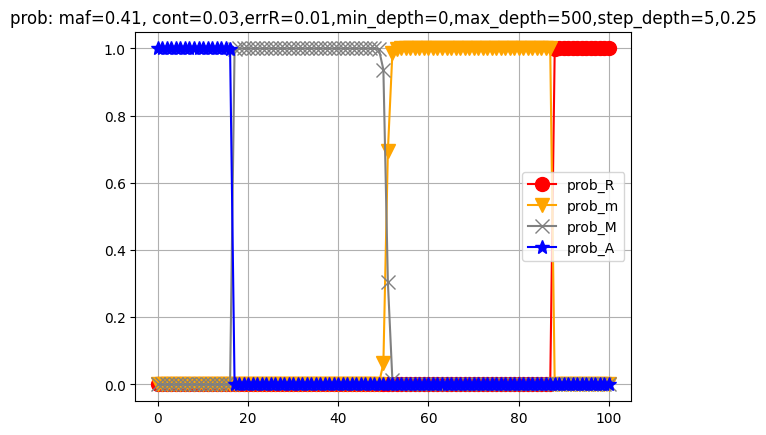

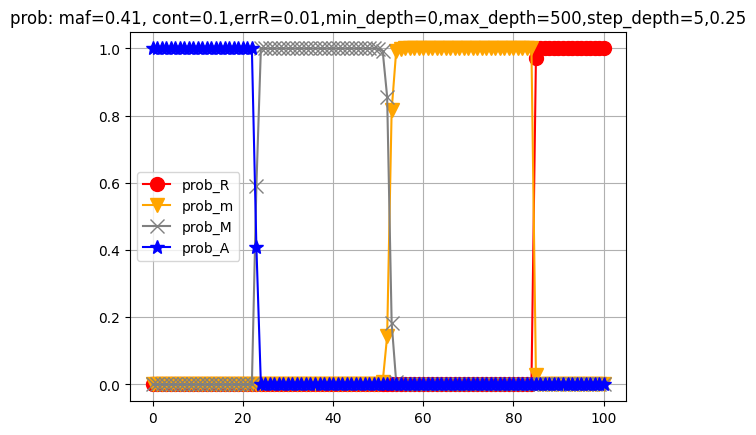

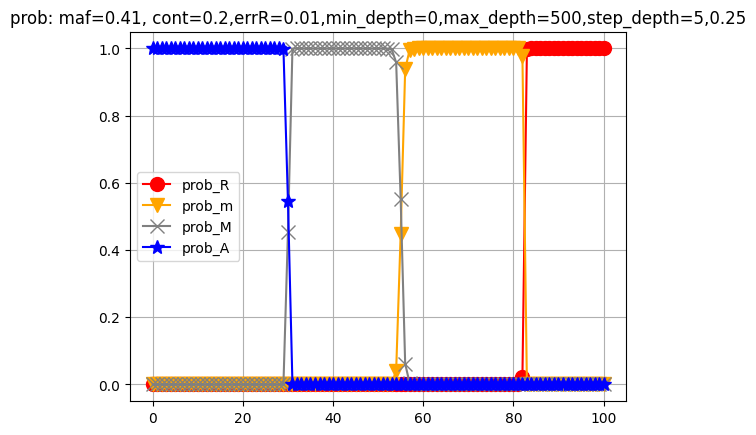

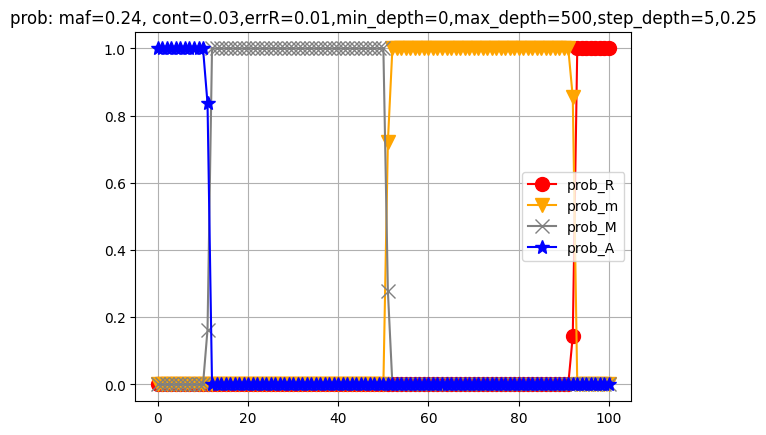

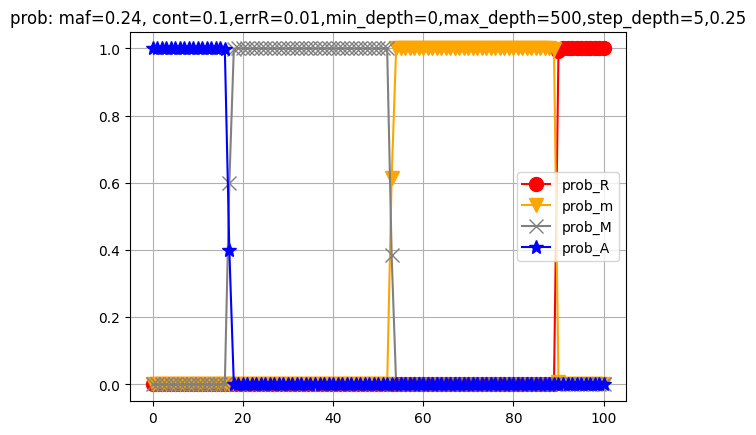

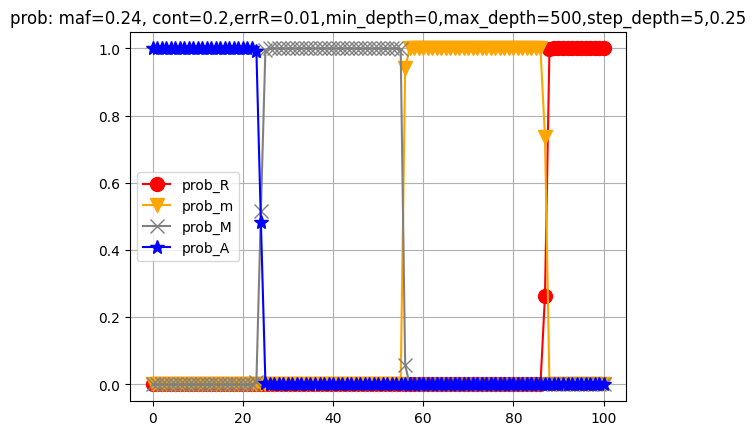

In [91]:
min_depth = 0
max_depth = 500
step_depth = 5
allele_frequency = 0.25
for maf in [ .41, .24]:
    for errR in [0.01]:
        # for cont in [ .2, .5]:
        for cont in [0.03, 0.1, 0.2]:
            frames=[]
            for ref_count in range(min_depth, max_depth+1,step_depth):
                alt_count = max_depth - ref_count
                # t = alt_count
                # alt_count = ref_count
                # ref_count = t
                site = {'allele_frequency':allele_frequency, 'ref_count':ref_count, 'alt_count':alt_count }
                p,d = probability(site, cont, errR, maf, 3)
                frames.append(d)
            dfs =  pd.concat(frames)
            dfs.reset_index(inplace=True,drop=True)
            # for pre in ['prob','psucc','pmf','p^k','(1-p)^(n-k)','gl']:
            # for pre in ['prob','psucc','pmf','gl']:
            # for pre in ['prob','psucc']:
            # for pre in ['gl','prob']:
            for pre in ['prob']:
                cols = [ f'{pre}_{a}' for a in ['R','m','M','A']]
                title = f'{pre}: maf={maf}, cont={cont},errR={errR},min_depth={min_depth},max_depth={max_depth},step_depth={step_depth},{allele_frequency}'
                plot_cols(dfs,cols,title)
                # print(p)
                # display(d.T)

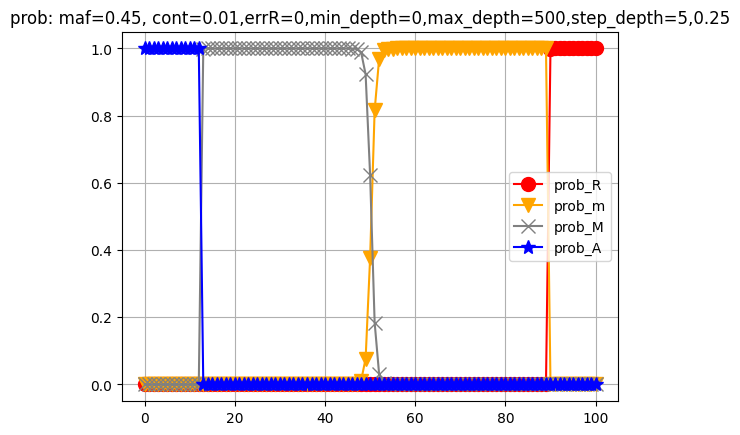

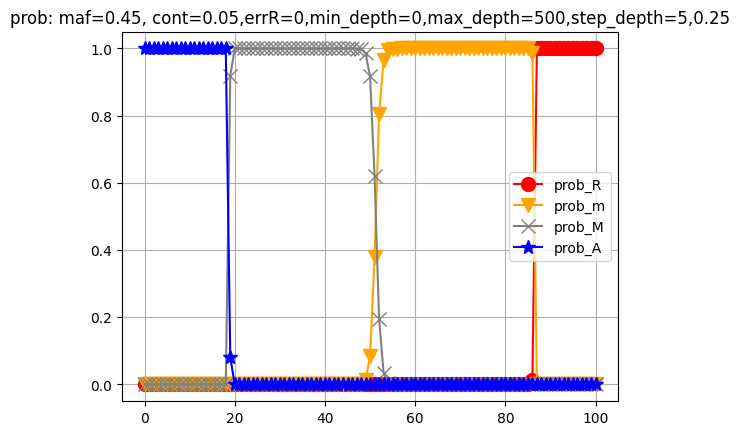

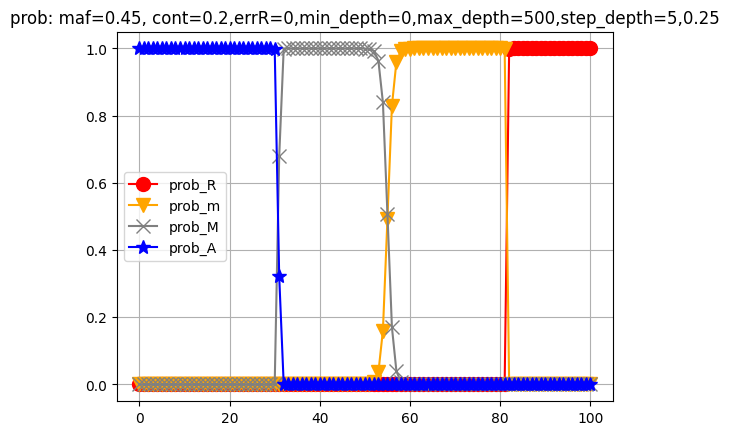

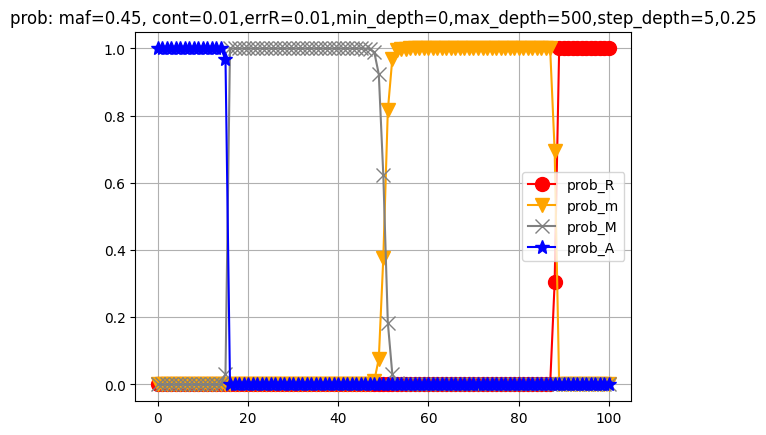

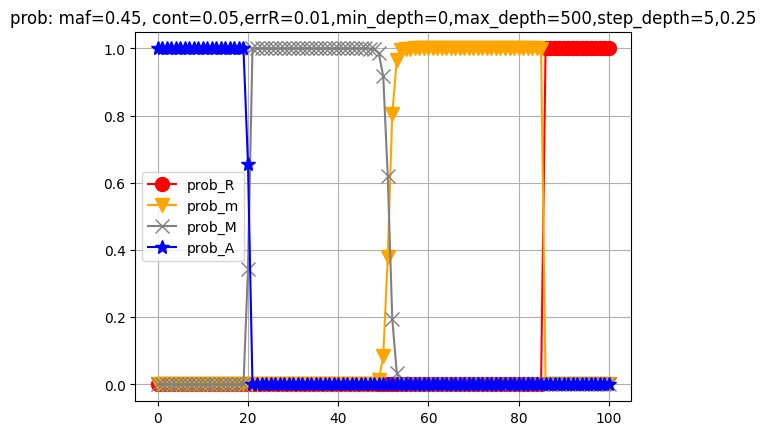

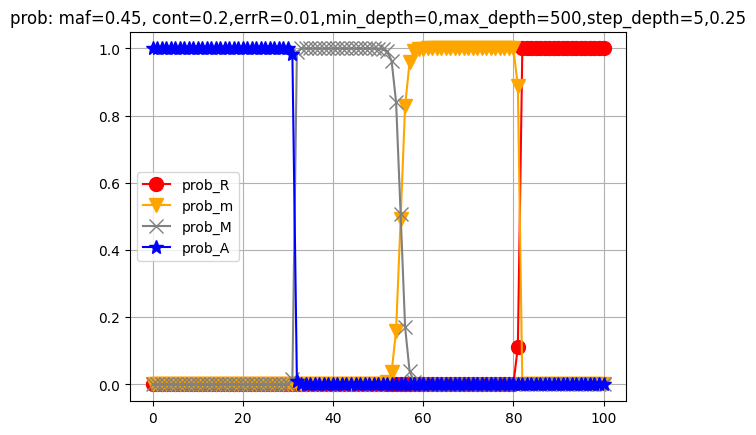

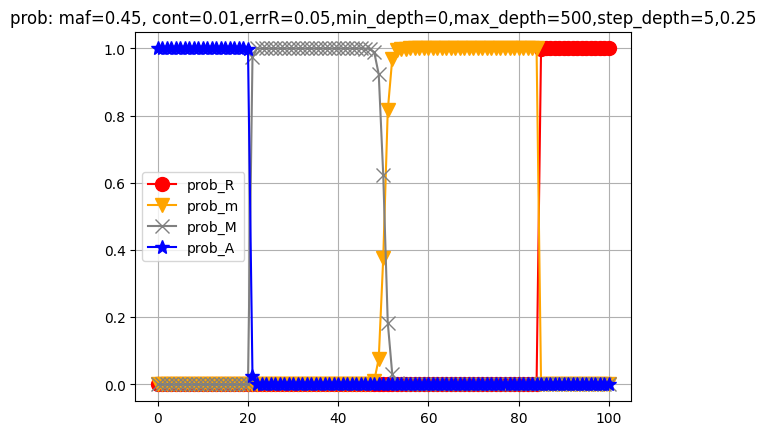

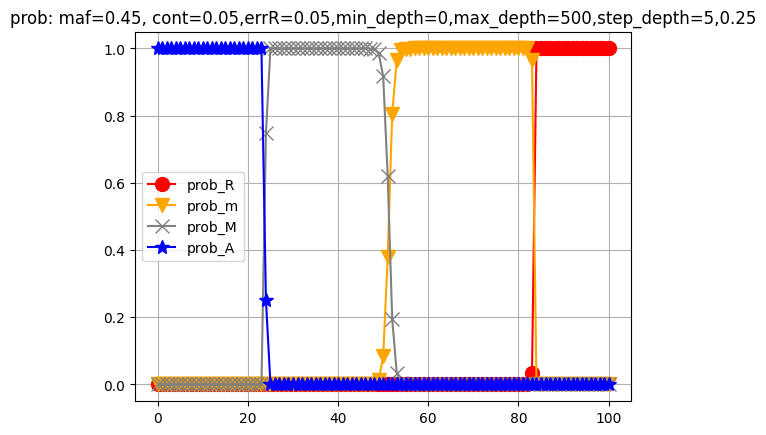

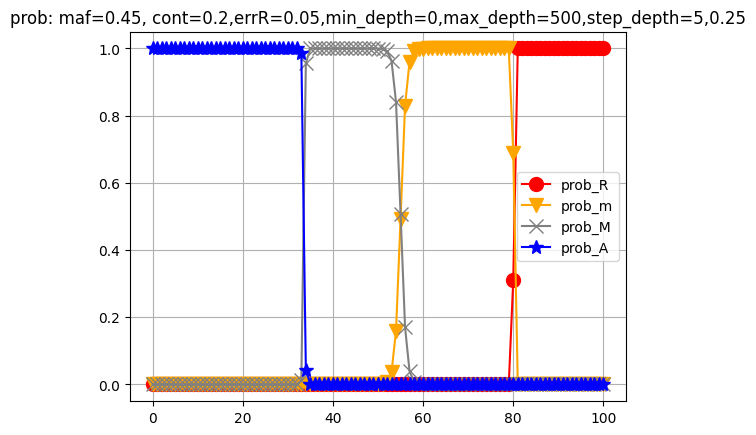

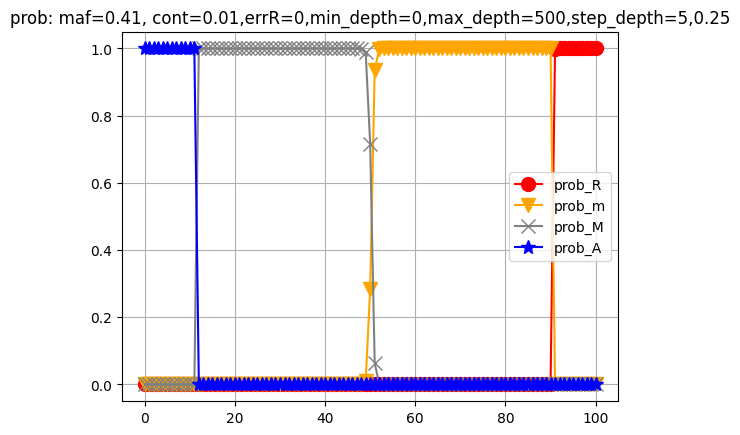

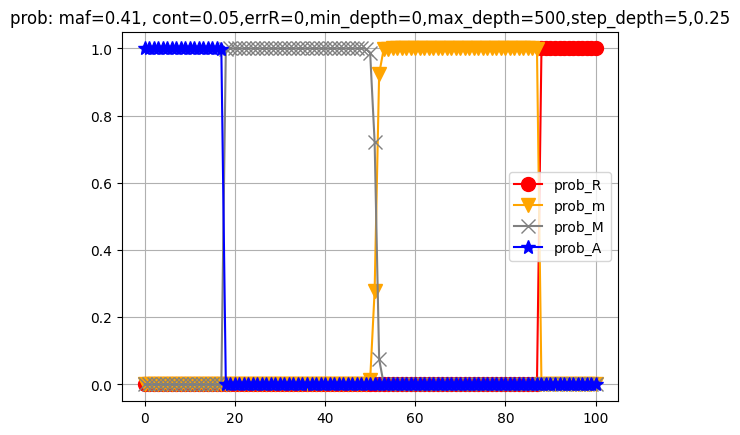

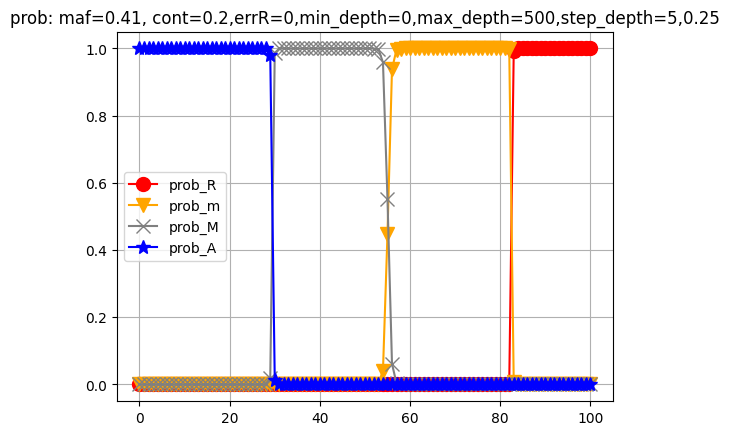

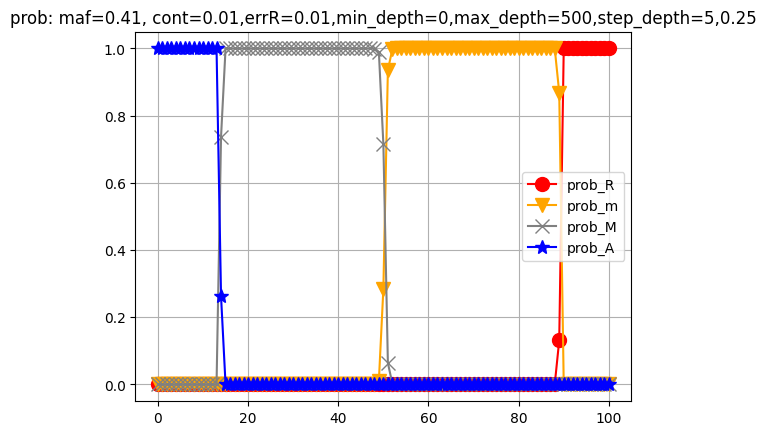

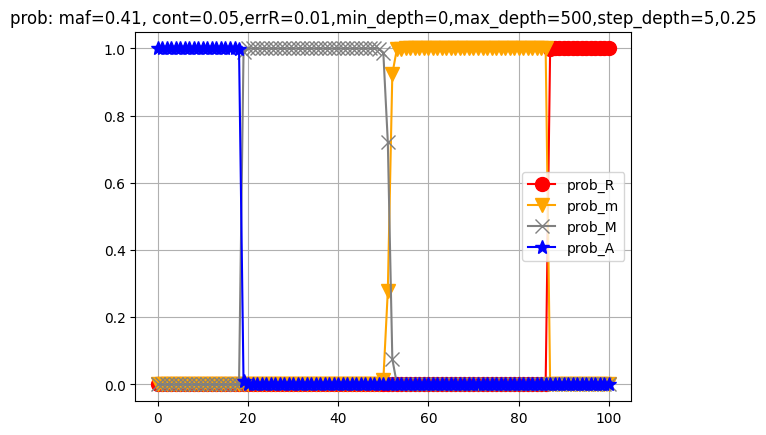

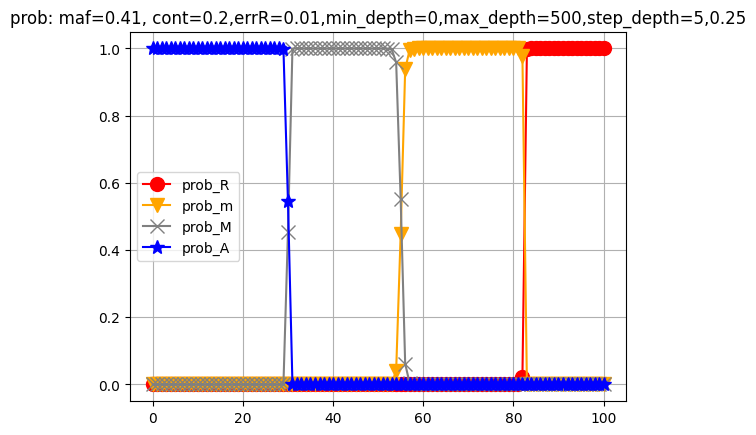

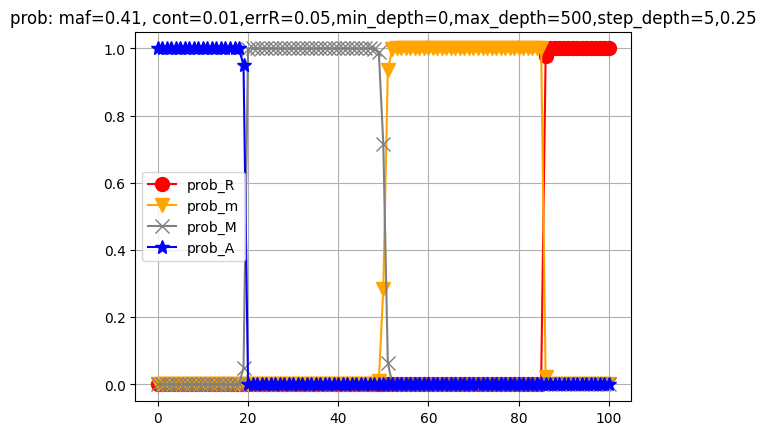

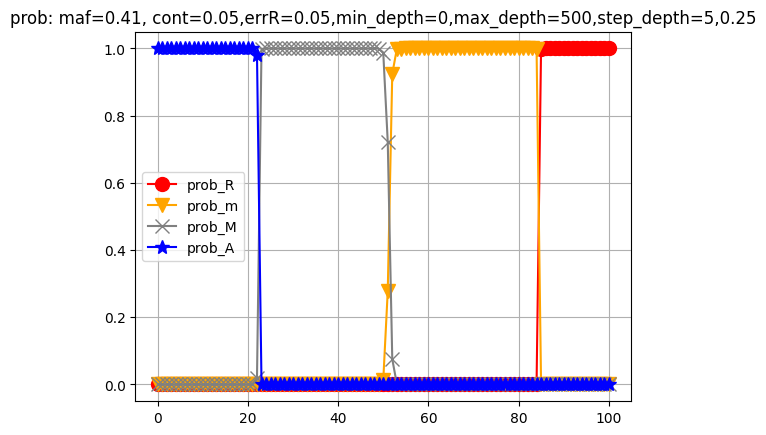

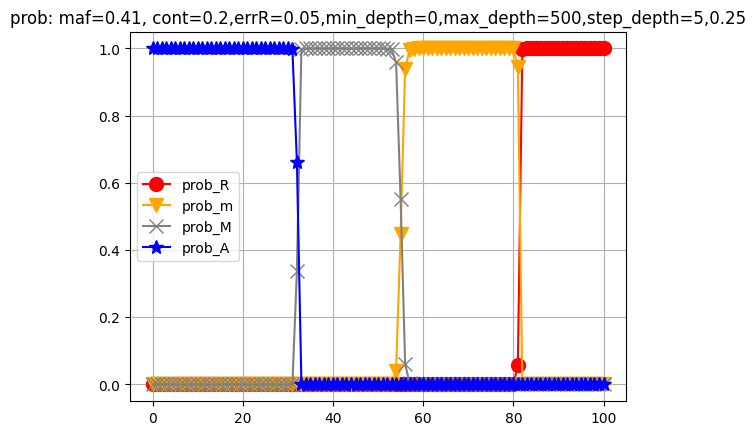

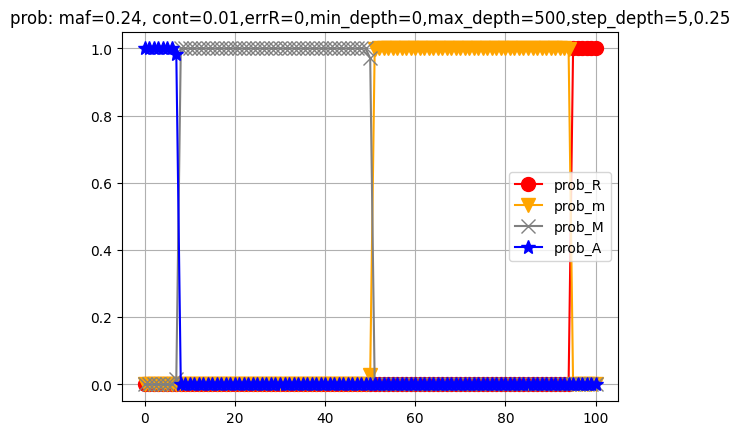

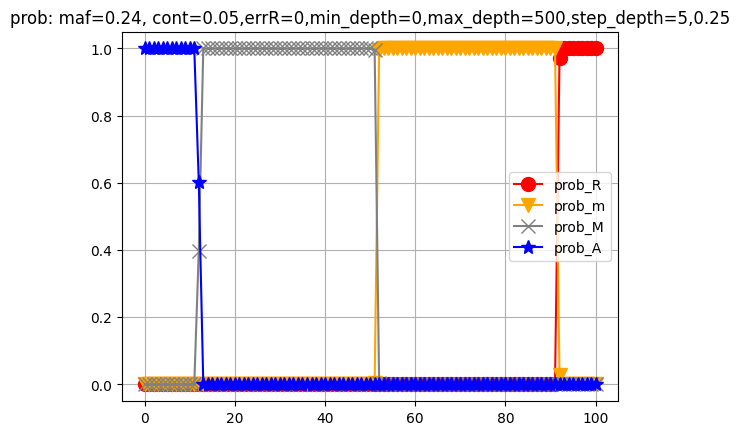

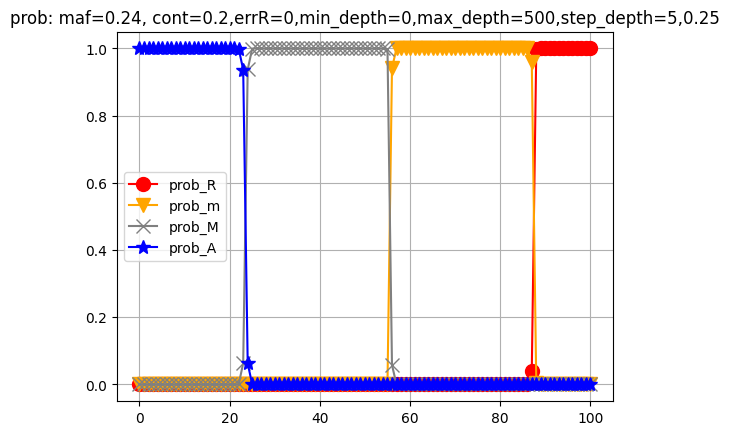

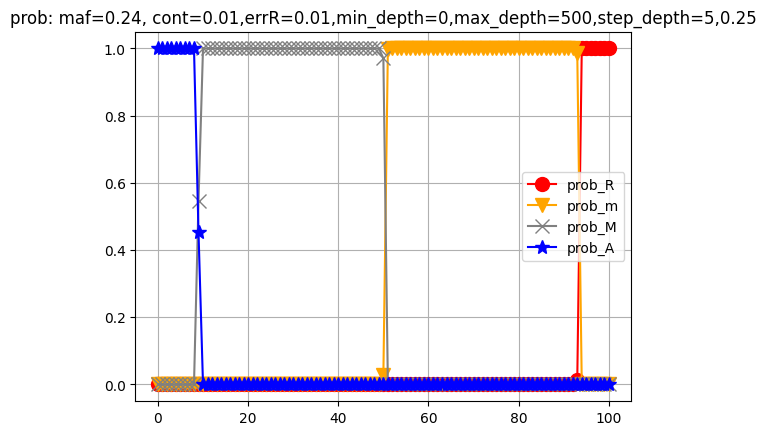

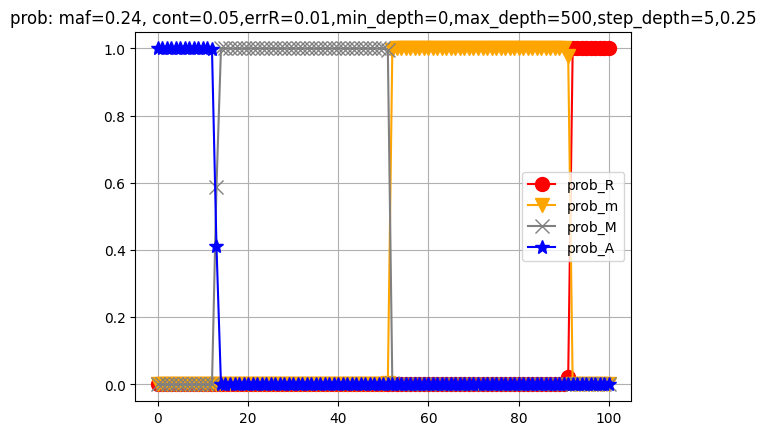

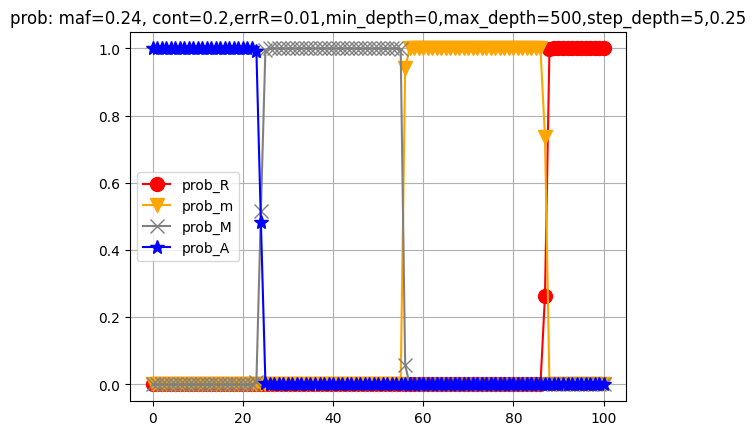

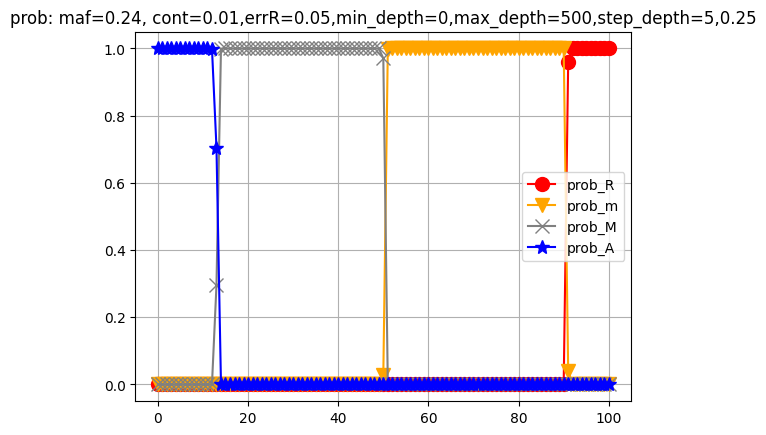

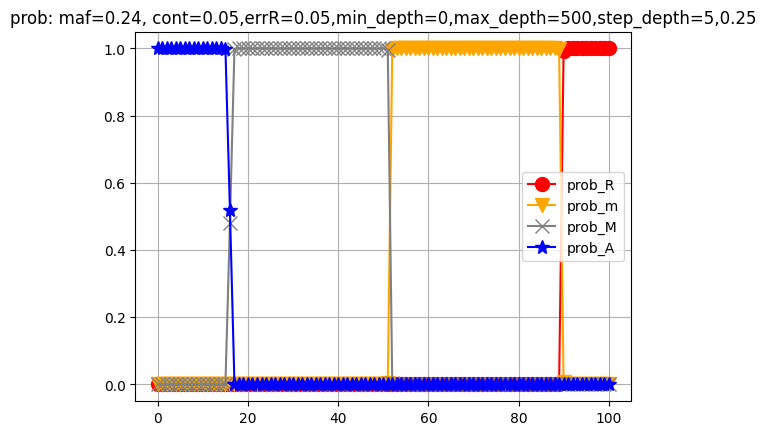

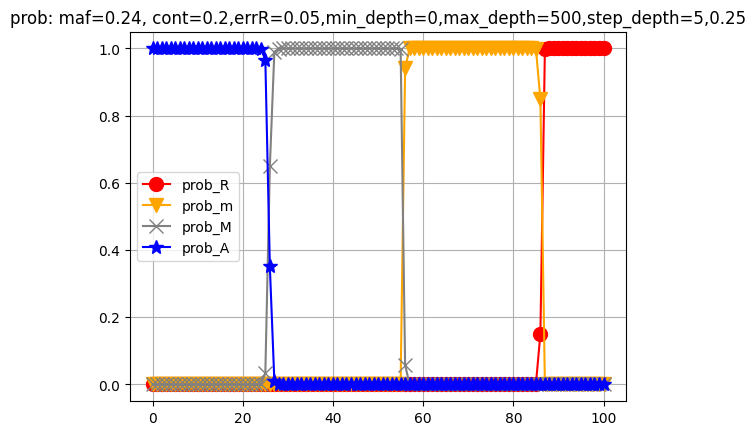

In [92]:
min_depth = 0
max_depth = 500
step_depth = 5
allele_frequency = 0.25
for maf in [.45, .41, .24]:
    for errR in [0, 0.01, 0.05]:
        for cont in [ .01, .05, .2]:
        # for cont in [0,0.01, 0.05, 0.1, 0.2]:
            frames=[]
            for ref_count in range(min_depth, max_depth+1,step_depth):
                alt_count = max_depth - ref_count
                # t = alt_count
                # alt_count = ref_count
                # ref_count = t
                site = {'allele_frequency':allele_frequency, 'ref_count':ref_count, 'alt_count':alt_count }
                p,d = probability(site, cont, errR, maf, 3)
                frames.append(d)
            dfs =  pd.concat(frames)
            dfs.reset_index(inplace=True,drop=True)
            # for pre in ['prob','psucc','pmf','p^k','(1-p)^(n-k)','gl']:
            # for pre in ['prob','psucc','pmf','gl']:
            # for pre in ['prob','psucc']:
            # for pre in ['gl','prob']:
            for pre in ['prob']:
                cols = [ f'{pre}_{a}' for a in ['R','m','M','A']]
                title = f'{pre}: maf={maf}, cont={cont},errR={errR},min_depth={min_depth},max_depth={max_depth},step_depth={step_depth},{allele_frequency}'
                plot_cols(dfs,cols,title)
                # print(p)
                # display(d.T)

# contamination plots

In [93]:
# @title plot_pearson
def plot_pearson(df, test_col, ref_col,xlabel,ylabel):
    if not df.shape[0] > 0:
        return None
    # get liner regression values
    slope, intercept, r_value, p_value, std_err = \
        linregress(df[[test_col, ref_col]].astype(float))
    r_squared = r_value ** 2
    # plot scatterplot with data
    fig, ax = plt.subplots()
    ax.scatter(df[test_col].astype(float).tolist(),
               df[ref_col].astype(float).tolist())

    # annotate graph with legend and titles
    ax.set_title(f'{test_col} vs. {ref_col} (n={len(df.index)}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_facecolor('whitesmoke')
    legend_elems = [
        Line2D([0], [0], marker='o', color='white',
               label='R = {}'.format(round(r_value, 5)), markersize=1)
    ]
    ax.legend(bbox_to_anchor=(.75, 1), handles=legend_elems, loc='best',borderaxespad=0.)

    # overlay slope line on graph
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, color='black')
    ax.grid(True)

In [94]:
# @title plot_all_contigs
def plot_all_contigs(normal,tumor,filter):
    if filter==True:
        n = read_filter_pileup(normal)
        t = read_filter_pileup(tumor)
        fig_title = 'Filtered pileup files'
        title= 'ps filtered at'
    else:
        n = read_unfilter_pileup(normal)
        t = read_unfilter_pileup(tumor)
        fig_title = 'Unfiltered pileup files'
        title= 'ps unfiltered at'
    n.insert(len(n.columns), f'class', 'normal')
    t.insert(len(t.columns), f'class', 'tumor')
    df=pd.concat([t,n])
    df.reset_index(inplace=True, drop=True)

    nr=6
    nc=4
    ir=0
    ic=0
    fig, axs = plt.subplots(nrows=nr, ncols=nc,figsize=(24, 16), sharey=True)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(fig_title)
    fig.subplots_adjust(hspace=.5)
    for con in df.contig.unique():
        cdf = df[df['contig']==con].copy()
        sns.scatterplot(x='ref_count', y='alt_count', data=cdf,hue='class', ax=axs[ir][ic],alpha=0.25)
        axs[ir][ic].set(title=f'{title} {con}')
        ic+=1
        if ic==4:
            ic=0
            ir+=1
    plt.show()

def plot_grid_all_contigs(normal,tumor,filter):
    if filter==True:
        n = read_filter_pileup(normal)
        t = read_filter_pileup(tumor)
        fig_title = 'Filtered pileup files'
    else:
        n = read_unfilter_pileup(normal)
        t = read_unfilter_pileup(tumor)
        fig_title = 'Unfiltered pileup files'
    n.insert(len(n.columns), f'class', 'normal')
    t.insert(len(t.columns), f'class', 'tumor')
    df=pd.concat([t,n])
    df.reset_index(inplace=True, drop=True)
    g = sns.FacetGrid(data=df, hue='class', col='contig', col_wrap=4,sharex=False,sharey=False)
    g.map(sns.scatterplot,'ref_count', 'alt_count', alpha=0.5)
    g.fig.subplots_adjust(top=0.92)
    g.fig.suptitle(fig_title)
    plt.legend()
    plt.show()

In [95]:
# @title plot_cdfs
def plot_cdfs(data1,data2, title, t11, n11, ax):
    x1_median=data1.median()
    x2_median=data2.median()
    x1 = np.sort(data1)
    y1 = np.arange(1, len(x1) + 1) / len(x1)

    x2 = np.sort(data2)
    y2 = np.arange(1, len(x2) + 1) / len(x2)
    # Plot the CDFs
    ax.plot(x1, y1, label=f'CDF {t11}', linestyle='-', color='blue')
    ax.plot(x2, y2, label=f'CDF {n11}', linestyle='--', color='orange')
    # ax.axhline(y=0.5, color='r', linestyle='-',)
    ax.axvline(x=x1_median, color='r', linestyle='-')
    ax.axvline(x=x2_median, color='r', linestyle='-')

    ax.set_xlabel('depth')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'CDF {title}')
    ax.legend()

In [96]:
# @title plot_pileup_depth
def plot_pileup_depth(normal,tumor, n11, t11, filter):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    if filter==True:
        n = read_filter_pileup(normal)
        t = read_filter_pileup(tumor)
        title = f'filter pileup depth {n11}, {t11}'
    else:
        n = read_unfilter_pileup(normal)
        t = read_unfilter_pileup(tumor)
        title = f'unfilter pileup depth {n11}, {t11}'
    n.insert(len(n.columns), f'class', 'normal')
    t.insert(len(t.columns), f'class', 'tumor')
    plot_cdfs(t.total_count, n.total_count,title, t11, n11, axs[0])
    nt=pd.concat([t,n])
    nt.reset_index(inplace=True, drop=True)
    sns.histplot(x='total_count', data=nt,hue='class', ax=axs[1])
    plt.title(title)
    descun=n[['total_count']].describe().T
    descut=t[['total_count']].describe().T
    descun.insert(0,f'class','normal')
    descut.insert(0,f'class','tumor')
    display(pd.concat([descun,descut]))

In [116]:
# @title ref_count by total vs alt_count by total
def ref_alt_count_by_total(ps,vaf=.25):
  df_filtered_ps = read_filter_pileup(ps)
  df_filtered_ps['ref_count_total'] = df_filtered_ps['ref_count']/ (df_filtered_ps['total_count']-df_filtered_ps['other_alt_count'])
  df_filtered_ps['alt_count_total'] = df_filtered_ps['alt_count']/ (df_filtered_ps['total_count']-df_filtered_ps['other_alt_count'])
  df_filtered_ps.plot(kind='scatter', x='ref_count_total', y='alt_count_total', s=32, alpha=.8)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.axvline(x=vaf, color='r', linestyle='-')
  plt.axvline(x=1-vaf, color='r', linestyle='-')

  plt.axhline(y=vaf, color='r', linestyle='-')
  plt.axhline(y=1-vaf, color='r', linestyle='-')

def ref_alt_count(ps):
  df_filtered_ps = read_filter_pileup(ps)
  df_filtered_ps.plot(kind='scatter', x='ref_count', y='alt_count', s=32, alpha=.8)
  plt.gca().spines[['top', 'right',]].set_visible(False)


In [97]:
from scipy.stats import linregress
from matplotlib.lines import Line2D

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pileup inputs

In [243]:

# @markdown Forms support many types of fields.
base_d='/content/drive/MyDrive/Colab Notebooks/data/eEHYw2/' # @param {type:"string"}
tumor_pileup_summary = 'aggz7kc3yjf4hmdrrhj5zebjiq_24-A31457_DSQ1.pileup_summaries_tumor.tsv' # @param {type:"string"}
normal_pileup_summary = 'aggz7kc3yjf4hmdrrhj5zebjiq_24-A27844_DSQ1.pileup_summaries_normal.tsv'  # @param {type: "string"}
t1_ps = f'{base_d}aggz7kc3yjf4hmdrrhj5zebjiq_24-A31457_DSQ1.pileup_summaries_tumor.tsv'
n1_ps = f'{base_d}aggz7kc3yjf4hmdrrhj5zebjiq_24-A27844_DSQ1.pileup_summaries_normal.tsv'
final_itr_t = 0  # @param {type: "number"}
final_itr_m = 0  # @param {type: "number"}

# @markdown ---


In [305]:
base_d='/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/'
t1_ps = f'{base_d}agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv'
n1_ps = f'{base_d}agg3itvvfnhntp6k3h3j7v242m_24-A29522_DSQ1.pileup_summaries_normal.tsv'
final_itr_t = 4
final_itr_m = 0

agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv
agg3itvvfnhntp6k3h3j7v242m_24-A29522_DSQ1.pileup_summaries_normal.tsv
agg3itvvfnhntp6k3h3j7v242m.tumor.contamination_4_homsSites.table.equal.final: model_contamination=0.0433466688551317, total sites=1076
agg3itvvfnhntp6k3h3j7v242m.tumor.matched.contamination_0_homsSites.table.equal.final: model_contamination=7.057535069217675E-4, total sites=61


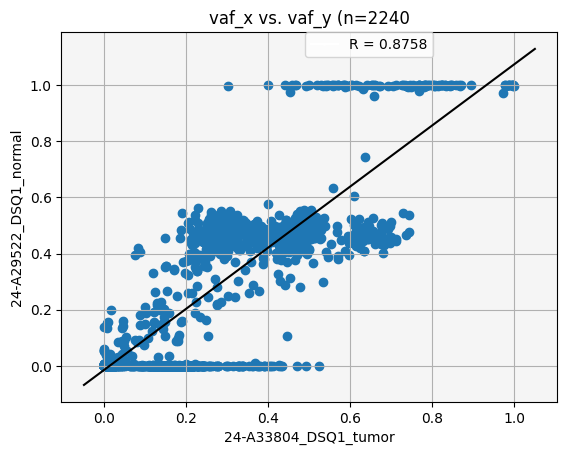

In [306]:
def split_ps_name(f1):
    f1= os.path.basename(f1)
    print(f1)
    aid = f1.split('_')[0]
    sp=f1.split(aid)[1].split('.')[0].split('_')
    iso = f'{sp[1]}_{sp[2]}'
    fclass = f1.split('_')[4].split('.')[0]
    return aid, iso, fclass

t1_aid, t1_iso, t1_class = split_ps_name(t1_ps)
t1_seg = f'{base_d}{t1_aid}.{t1_class}.segments'
t11= f'{t1_iso}_{t1_class}'

n1_aid, n1_iso, n1_class = split_ps_name(n1_ps)
n1_seg = f'{base_d}{n1_aid}.{n1_class}.segments'
n11= f'{n1_iso}_{n1_class}'

d1 = read_filter_pileup(t1_ps)
d2 = read_filter_pileup(n1_ps)
d1['vaf'] = d1['alt_count']/ d1['total_count']
d2['vaf'] = d2['alt_count']/ d2['total_count']
m = d1.merge(d2,how='inner',on=['contig','position'])

# gatk output meta
final_T = f'{base_d}/{t1_aid}.tumor.contamination_{final_itr_t}_homsSites.table.equal.final'
final_M = f'{base_d}/{t1_aid}.tumor.matched.contamination_{final_itr_m}_homsSites.table.equal.final'

model_contamination_T, df_final_T = final_info(final_T)
model_contamination_M, df_final_M = final_info(final_M)
df_final_T.insert(len(df_final_T.columns), f'class', 'tumor')
df_final_M.insert(len(df_final_M.columns), f'class', 'matched')
final_TM=pd.concat([df_final_T,df_final_M])
final_TM.reset_index(inplace=True, drop=True)
final_TM=renxy(final_TM)
final_TM
plot_pearson(m,'vaf_x','vaf_y',t11,n11)

,contig,start_1,start_2,end_1,end_2,maf_24-A33804_DSQ1_tumor,maf_24-A29522_DSQ1_normal
0,1,6257826,6257826.0,245027349,245027349.0,0.285410,0.460465
1,2,21228827,21231524.0,240111521,234591205.0,0.285410,0.456132
2,3,10077955,10077955.0,195702738,195701472.0,0.272556,0.400000
3,4,1806519,20492417.0,187630989,187630989.0,0.272556,0.459137
4,5,1255520,1593266.0,180056044,180056044.0,0.285410,0.464810
5,6,29691772,29691772.0,162864317,160148410.0,0.248327,0.369793
6,7,1533513,2968361.0,158827326,158827326.0,0.269004,0.356231
7,8,11614575,11614575.0,145741765,145741765.0,0.356231,0.414000
8,9,5050706,5050706.0,139413908,139410177.0,0.298538,0.460931
9,10,3819714,3819714.0,131506283,131506283.0,0.304547,0.465567


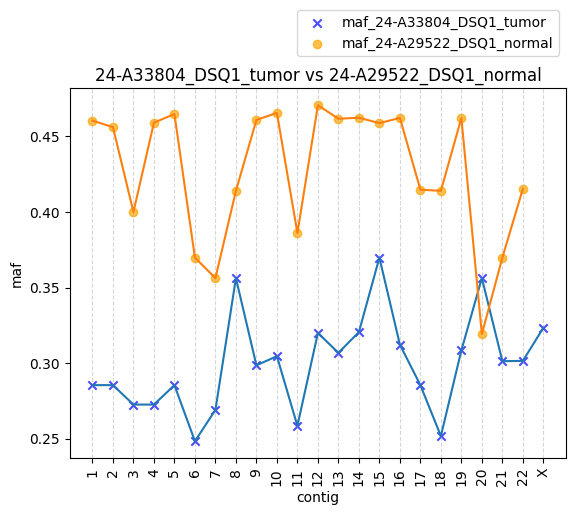

In [307]:
plot_seg(t1_seg,n1_seg,t11,n11,False)

In [241]:
t1_ps

'drive/MyDrive/Colab Notebooks/data/eEHYw2/aggz7kc3yjf4hmdrrhj5zebjiq_24-A31457_DSQ1.pileup_summaries_tumor.tsv'

In [242]:
/content/drive/MyDrive/Colab Notebooks/data/eEHYw2/aggz7kc3yjf4hmdrrhj5zebjiq_24-A31457_DSQ1.pileup_summaries_tumor.tsv

NameError: name 'content' is not defined

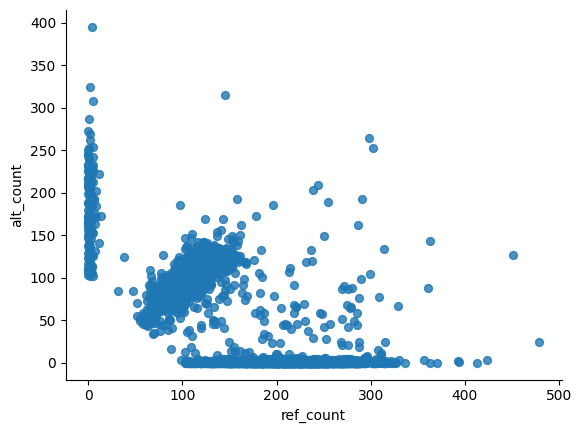

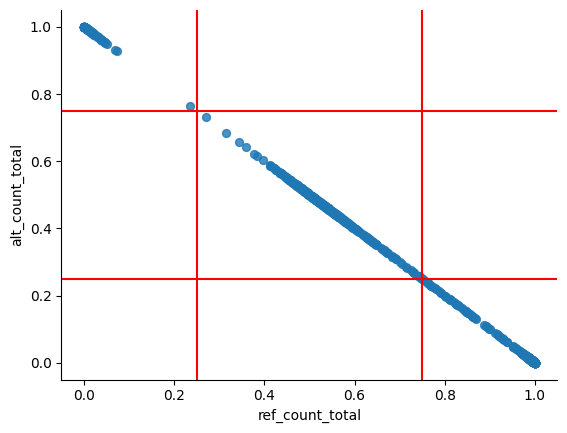

In [110]:
ref_alt_count(t1_ps)
ref_alt_count_by_total(t1_ps)

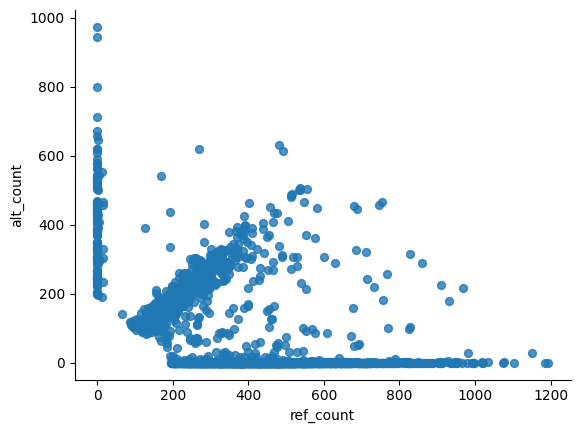

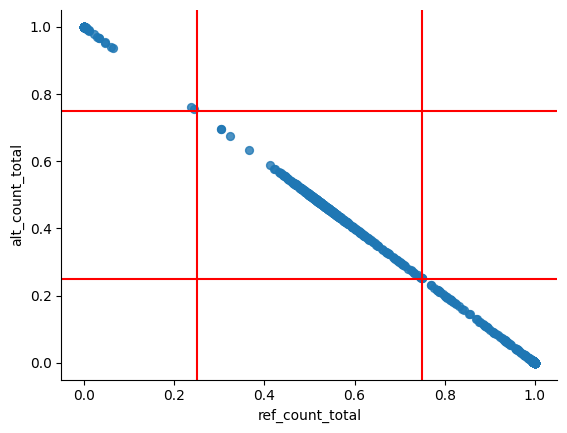

In [111]:
ref_alt_count(n1_ps)
ref_alt_count_by_total(n1_ps)


In [210]:
plot_seg(t1_seg,n1_seg,t11,n11)

ValueError: invalid literal for int() with base 10: 'X'

In [ ]:
plot_pileup_depth(n1_ps,t1_ps,n11, t11, filter=False)

In [ ]:
plot_pileup_depth(n1_ps,t1_ps,n11, t11, filter=True)

In [ ]:
plot_all_contigs(n1_ps,t1_ps,filter=True)

In [ ]:
# plot_grid_all_contigs(n1_ps,t1_ps,filter=True)

# plot final files

In [ ]:
sum_t_ref = sum(final_TM[final_TM['class']=='tumor'].ref_count)
sum_m_ref = sum(final_TM[final_TM['class']=='matched'].ref_count)

g = sns.FacetGrid(data=final_TM, hue='class', col='contig', col_wrap=4,sharex=False)
g.map(sns.scatterplot,'ref_count', 'alt_count', alpha=0.5)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle(f'Loci used for contamination from final files:\n matched at iteration {final_itr_m}, ref count = {sum_m_ref}, tumor at iteration {final_itr_t}, ref count = {sum_t_ref}')
g.add_legend()
plt.show()

 # Calculate GATK HOM_ALT

In [308]:
df_filtered_ps = read_filter_pileup(t1_ps)
display(df_filtered_ps)
model_contamination = model_contamination_M
print(model_contamination)
t1_seg
t1_ps
# for minMaf in [.4, .36, .32, .28]:
for minMaf in [.28]:
    a4, an4 = calculateContamination(t1_ps, 'HOM_ALT', df_filtered_ps, t1_seg, model_contamination, minMaf, None, None, None, False)
    print(f'HOM_ALT at {minMaf} = {a4} from {an4.shape[0]} sites')
# r4, rn4 = calculateContamination(n1, 'HOM_REF', df_filtered_ps, ns1, model_contamination, minMaf, None, None, None, False)
# print(f'HOM_REF at {minMaf} = {r4} from {rn4.shape[0]} sites')

,contig,position,ref_count,alt_count,other_alt_count,allele_frequency,total_count
5,1,2494330,511,2,0,0.1278420,513
16,1,6257826,407,188,0,0.3113280,595
17,1,6257856,291,281,0,0.4872950,572
21,1,7982034,379,8,0,0.2500000,387
22,1,8064557,383,0,0,0.0645161,383
...,...,...,...,...,...,...,...
5275,X,129147373,634,0,0,0.0721262,634
5276,X,129186012,216,143,0,0.1886140,359
5286,X,153760508,568,0,0,0.2316880,568
5287,X,153760654,553,0,0,0.1647800,553


7.057535069217675E-4
calling homAlts(/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv, /content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m.tumor.segments, 7.057535069217675E-4, 0.28)
getType ps_file=/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m_24-A33804_DSQ1.pileup_summaries_tumor.tsv, segments_file=/content/drive/MyDrive/Colab Notebooks/data/GS9VVO/agg3itvvfnhntp6k3h3j7v242m.tumor.segments


,contig,start,end,minor_allele_fraction
0,22,21337266,42538897,0.301451
1,11,193096,128391937,0.258484
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
8,18,673016,60612536,0.251713
9,19,580665,59067623,0.308436


,contig,start,end,minor_allele_fraction
0,22,21337266,42538897,0.301451
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
9,19,580665,59067623,0.308436
10,1,6257826,245027349,0.285410
11,2,21228827,240111521,0.285410


'find segments sites


,contig,start,end,maf
0,1,6257826,245027349,0.285410
1,10,3819714,131506283,0.304547
2,12,406292,133263825,0.319984
3,13,21720956,110435231,0.306790
4,14,20841162,105242966,0.320509
5,15,33023486,93555717,0.369793
6,16,450165,81971403,0.312223
7,17,7217944,80788492,0.285410
8,19,580665,59067623,0.308436
9,2,21228827,240111521,0.285410


NameError: name 'errorRate' is not defined